# Project 1 (Case 2)
In this section we investigate the effects of COVID-10 on prediction accuracy using a neural network applied to the historic trading prices for CBA.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [2]:
figure_path = 'figures/'
dpi = 300

## Exploratory data analysis
We begin by importing the data and generating some summary visuals.

In [3]:
raw_data = pd.read_csv('../data/CBA.AX.csv', parse_dates=['Date'])
raw_data = raw_data.set_index('Date')

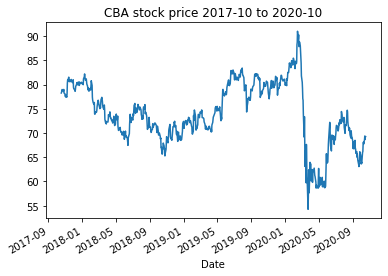

In [4]:
raw_data['Close'].plot(title='CBA stock price 2017-10 to 2020-10')
plt.savefig(figure_path + 'f2_tseries.png', dpi=dpi, bbox_inches='tight')
plt.show()

The large drop during COVID-19 is very clear. I will take it that the date COVID-19 started is 15/2/2020.

## Feature engineering
First we will need to use the time series to construct some features which will be used for prediction.

In [5]:
series = raw_data['Close']

In [6]:
series_standardised = (series - series.mean()) / series.std()

In [7]:
def generate_features(series, n_features, steps_ahead):
    len_series = len(series)
    X, y = [], []
    for i in range(len_series - n_features - steps_ahead):
        Xs, ys = series[i:i+n_features].values, series[i+n_features:i+n_features+steps_ahead].values
        X.append(Xs)
        y.append(ys)
    X, y = np.vstack(X), np.vstack(y)
    return X, y

In [8]:
X, y = generate_features(series_standardised, n_features=5, steps_ahead=5)

In [9]:
covid_date_index = len(series[:'2020-02-17'])
covid_date_index_plus_50_perc = int(covid_date_index + np.floor((len(series) - covid_date_index)/2))

In [10]:
X_train_1, y_train_1 = X[:covid_date_index], y[:covid_date_index]
X_test_1, y_test_1 = X[covid_date_index:], y[covid_date_index:]

X_train_2, y_train_2 = X[:covid_date_index_plus_50_perc], y[:covid_date_index_plus_50_perc]
X_test_2, y_test_2 = X[covid_date_index_plus_50_perc:], y[covid_date_index_plus_50_perc:]

## Experimenting with a simple classifier
Before building a neural network, we first experiment with a simple linear regression. This is simply multiple-output regression, where a model is fit for each of the $5$ outputs.

In [11]:
model_1 = LinearRegression()

model_1.fit(X_train_1, y_train_1)
print('Model 1 R2: {:.4f}'.format(model_1.score(X_test_1,y_test_1)))

model_2 = LinearRegression()

model_2.fit(X_train_2, y_train_2)
print('Model 2 R2: {:.4f}'.format(model_2.score(X_test_2, y_test_2)))

Model 1 R2: 0.7008
Model 2 R2: 0.7387


Unsurprisingly, baseline performance improves when we consider more data from the COVID-19 period.

## Building a neural network
We now proceed to building a baseline neural network, which will later be improved upon.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5,32)
        self.fc2 = nn.Linear(32,5)
        
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        return x

In [13]:
overall_dataset = {
    'X': torch.from_numpy(X).type(torch.float)
}

## Training a neural network
We are now ready to train our neural network.

In [14]:
train_dataset = TensorDataset(
    torch.from_numpy(X_train_1).type(torch.float),
    torch.from_numpy(y_train_1).type(torch.float),
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = {
    'X': torch.from_numpy(X_test_1).type(torch.float),
    'y': torch.from_numpy(y_test_1).type(torch.float)
}

In [15]:
model = Net()

In [16]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [17]:
n_epochs = 1000

train_losses, test_losses = [], []
test_r2s = []

for e in range(n_epochs):
    
    model.train()
    for ii, (train_inputs, train_responses) in enumerate(train_dataloader):
        optimizer.zero_grad() 

        train_output = model(train_inputs)
        train_loss = criterion(train_output, train_responses)

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item() / train_inputs.shape[0])
    
    model.eval()
    test_inputs, test_responses = test_dataset['X'], test_dataset['y']
    with torch.no_grad():
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_responses)
        
        test_r2 = r2_score(test_responses, test_output)
        
    test_losses.append(test_loss)
    test_r2s.append(test_r2)

In [18]:
window_length = 50
train_losses_averaged = np.convolve(np.array(train_losses), 
                                    np.ones((window_length,)) / window_length, 
                                    mode='valid')

In [19]:
model.eval()
with torch.no_grad():
    predictions = model(overall_dataset['X']).numpy()
    
predictions_1step = pd.Series(np.NaN, index=series_standardised.index)
predictions_1step[5:-5] = predictions[:,0]

predictions_5step = pd.Series(np.NaN, index=series_standardised.index)
predictions_5step[10:] = predictions[:,4]

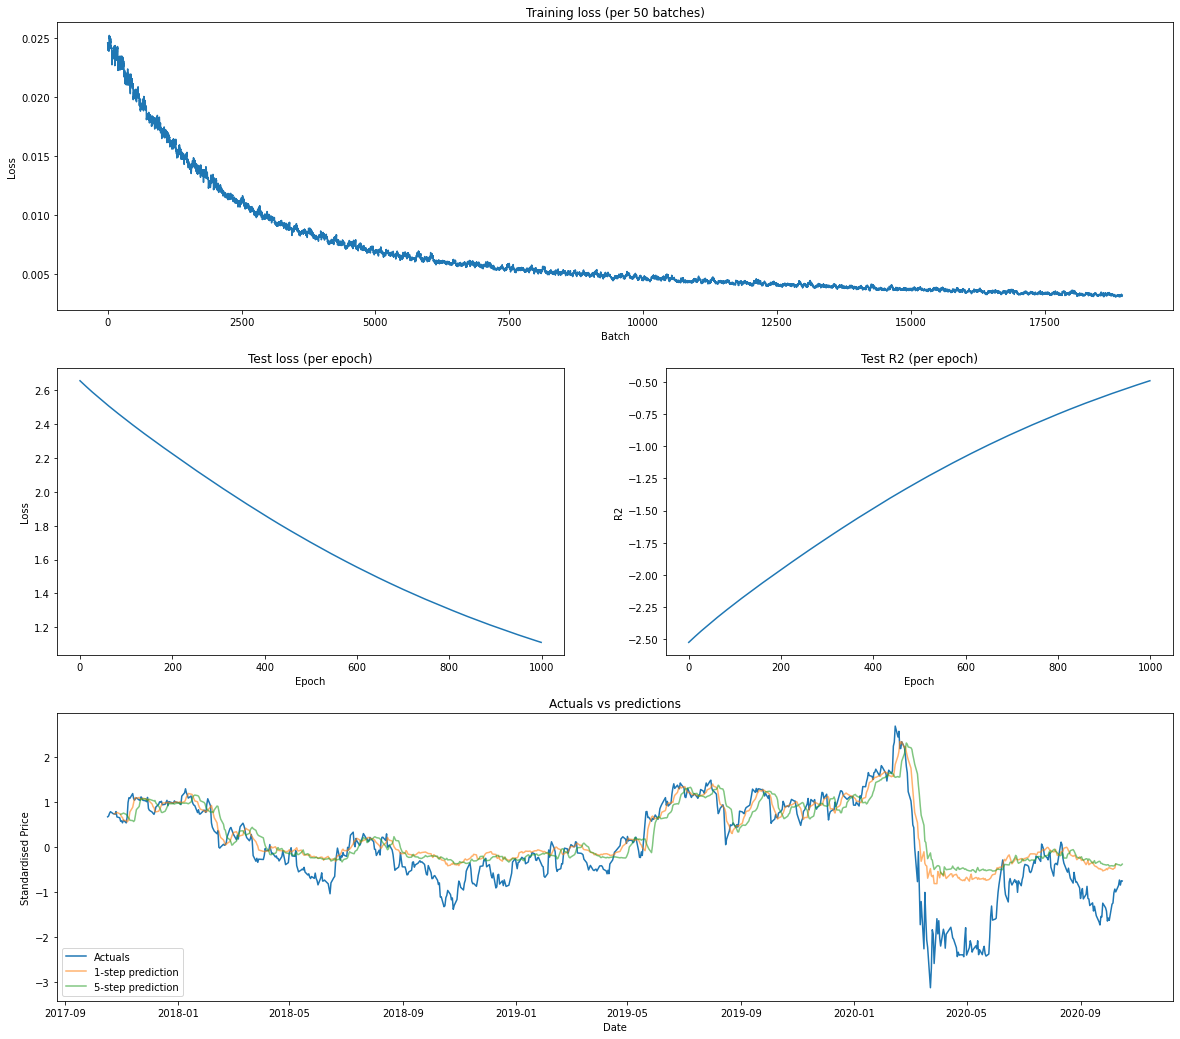

In [20]:
fig = plt.figure(figsize=(20,18))
gs = GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, :])

ax1.plot(train_losses_averaged)
ax2.plot(test_losses)
ax3.plot(test_r2s)

ax4.plot(series_standardised, label='Actuals')
ax4.plot(predictions_1step, label='1-step prediction', alpha=0.6)
ax4.plot(predictions_5step, label='5-step prediction', alpha=0.6)
ax4.legend(loc='lower left')

ax1.set_title('Training loss (per 50 batches)')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')

ax2.set_title('Test loss (per epoch)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.set_title('Test R2 (per epoch)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('R2')

ax4.set_title('Actuals vs predictions')
ax4.set_xlabel('Date')
ax4.set_ylabel('Standardised Price')

plt.savefig(figure_path + 'f2_firstattempt_1.png', dpi=dpi, bbox_inches='tight')
plt.show()

Training loss and test loss flatten out, and a large gap persists between predictions and actuals during the COVID-19 period. Let us try again with the same model but using instead 50% of the training data from the COVID-19 period.

In [21]:
train_dataset = TensorDataset(
    torch.from_numpy(X_train_2).type(torch.float),
    torch.from_numpy(y_train_2).type(torch.float),
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = {
    'X': torch.from_numpy(X_test_2).type(torch.float),
    'y': torch.from_numpy(y_test_2).type(torch.float)
}

In [22]:
model = Net()

In [23]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [24]:
n_epochs = 1000

train_losses, test_losses = [], []
test_r2s = []

for e in range(n_epochs):
    
    model.train()
    for ii, (train_inputs, train_responses) in enumerate(train_dataloader):
        optimizer.zero_grad() 

        train_output = model(train_inputs)
        train_loss = criterion(train_output, train_responses)

        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item() / train_inputs.shape[0])
    
    model.eval()
    test_inputs, test_responses = test_dataset['X'], test_dataset['y']
    with torch.no_grad():
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_responses)
        
        test_r2 = r2_score(test_responses, test_output)
        
    test_losses.append(test_loss)
    test_r2s.append(test_r2)

In [25]:
window_length = 50
train_losses_averaged = np.convolve(np.array(train_losses), 
                                    np.ones((window_length,)) / window_length, 
                                    mode='valid')

In [26]:
model.eval()
with torch.no_grad():
    predictions = model(overall_dataset['X']).numpy()
    
predictions_1step = pd.Series(np.NaN, index=series_standardised.index)
predictions_1step[5:-5] = predictions[:,0]

predictions_5step = pd.Series(np.NaN, index=series_standardised.index)
predictions_5step[10:] = predictions[:,4]

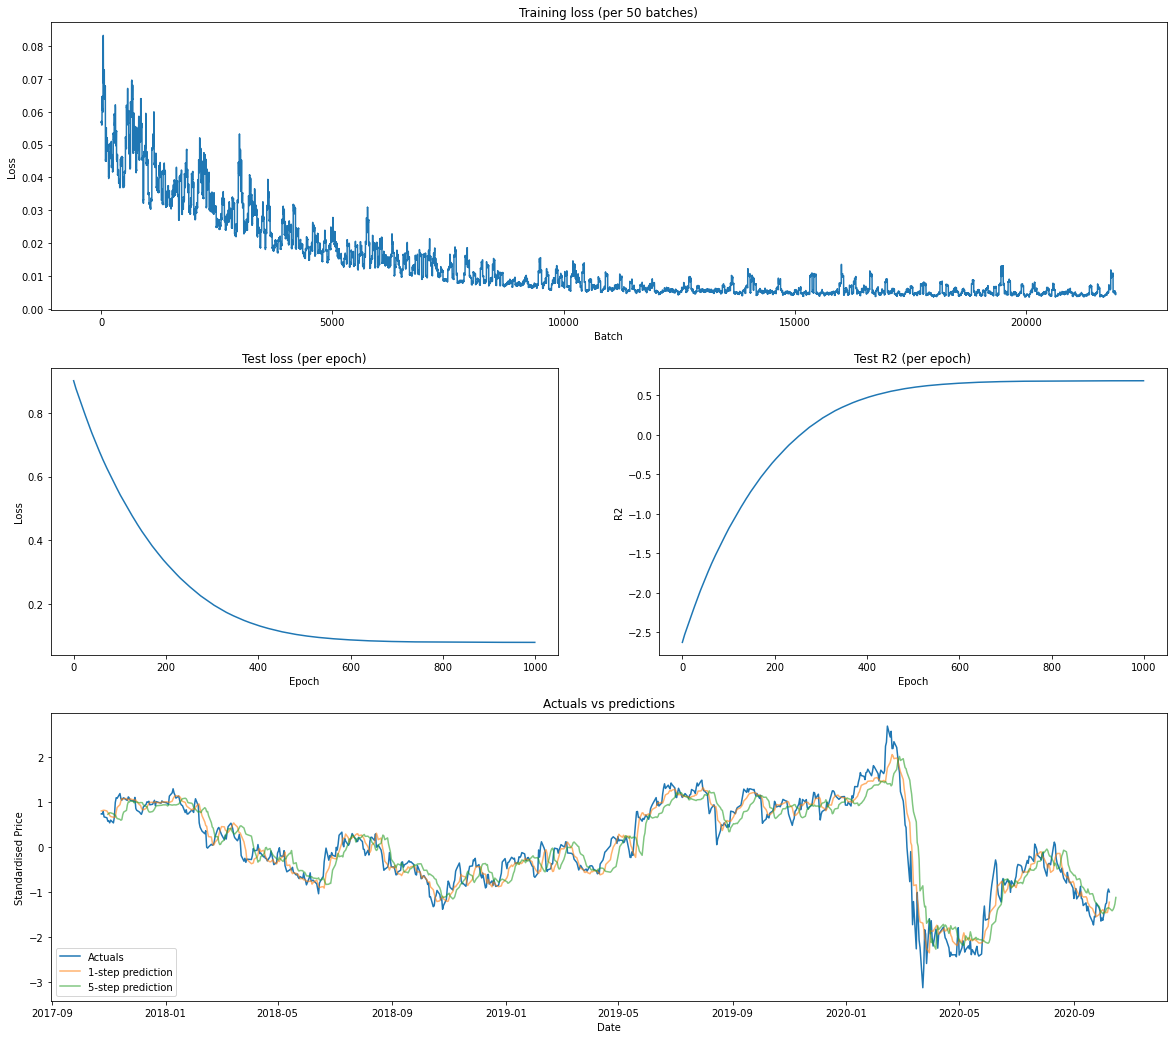

In [27]:
fig = plt.figure(figsize=(20,18))
gs = GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, :])

ax1.plot(train_losses_averaged)
ax2.plot(test_losses)
ax3.plot(test_r2s)

ax4.plot(series_standardised[5:-5], label='Actuals')
ax4.plot(predictions_1step, label='1-step prediction', alpha=0.6)
ax4.plot(predictions_5step, label='5-step prediction', alpha=0.6)
ax4.legend(loc='lower left')

ax1.set_title('Training loss (per 50 batches)')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')

ax2.set_title('Test loss (per epoch)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.set_title('Test R2 (per epoch)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('R2')

ax4.set_title('Actuals vs predictions')
ax4.set_xlabel('Date')
ax4.set_ylabel('Standardised Price')

plt.savefig(figure_path + 'f2_firstattempt_2.png', dpi=dpi, bbox_inches='tight')
plt.show()

This time predictions track actuals much more accurately during the COVID-19 period, as expected.

## Experimentation
Now we consider a number of experiments. Before doing so, we first wrap some of the above code into functions.

In [28]:
def train_model(train_dataloader, test_dataset, 
                  network, optimizer, criterion, n_epochs, 
                  experiment_name, window_length=50):
    
    train_losses, test_losses = [], []
    test_r2s = []
    
    for e in range(n_epochs):

        model.train()
        for ii, (train_inputs, train_responses) in enumerate(train_dataloader):
            optimizer.zero_grad() 

            train_output = network(train_inputs)
            train_loss = criterion(train_output, train_responses)

            train_loss.backward()
            optimizer.step()

            train_losses.append(train_loss.item() / train_inputs.shape[0])

        model.eval()
        test_inputs, test_responses = test_dataset['X'], test_dataset['y']
        with torch.no_grad():
            test_output = network(test_inputs)
            test_loss = criterion(test_output, test_responses)

            test_r2 = r2_score(test_responses, test_output)

        test_losses.append(test_loss)
        test_r2s.append(test_r2)
        
    train_losses_averaged = np.convolve(np.array(train_losses), 
                                        np.ones((window_length,)) / window_length, 
                                        mode='valid')
    
    model.eval()
    with torch.no_grad():
        predictions = network(overall_dataset['X']).numpy()
    
    predictions_1step = pd.Series(np.NaN, index=series_standardised.index)
    predictions_1step[5:-5] = predictions[:,0]

    predictions_5step = pd.Series(np.NaN, index=series_standardised.index)
    predictions_5step[10:] = predictions[:,4]
    
    results = {'train_losses': train_losses,
               'train_losses_averaged': train_losses_averaged,
               'test_losses': test_losses, 
               'test_r2s': test_r2s,
               'predictions_1step': predictions_1step,
               'predictions_5step': predictions_5step,
               'experiment_name': experiment_name}
    return results

def plot_results(experiment_results, fig_name=None, window_length=50):
    
    fig = plt.figure(figsize=(20,12))
    gs = GridSpec(ncols=2, nrows=2, figure=fig)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    
    for experiment in experiment_results:
        ax1.plot(experiment['train_losses_averaged'], label=experiment['experiment_name'])
        ax2.plot(experiment['test_losses'], alpha=0.8)
        ax3.plot(experiment['test_r2s'], alpha=0.8)

    ax1.set_title('Training loss (mean per {} batches)'.format(str(window_length)))
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    ax2.set_title('Test loss (per epoch)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')

    ax3.set_title('Test R2 (per epoch)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('R2')
    
    if fig_name:
        fig.savefig(figure_path + 'f2_' + fig_name + '.png', 
                dpi=dpi, bbox_inches='tight')

In [29]:
train_dataset_1 = TensorDataset(
    torch.from_numpy(X_train_1).type(torch.float),
    torch.from_numpy(y_train_1).type(torch.float),
)

train_dataloader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)

test_dataset_1 = {
    'X': torch.from_numpy(X_test_1).type(torch.float),
    'y': torch.from_numpy(y_test_1).type(torch.float),
}


train_dataset_2 = TensorDataset(
    torch.from_numpy(X_train_2).type(torch.float),
    torch.from_numpy(y_train_2).type(torch.float),
)

train_dataloader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=True)

test_dataset_2 = {
    'X': torch.from_numpy(X_test_2).type(torch.float),
    'y': torch.from_numpy(y_test_2).type(torch.float),
}

### 1. Optimisers
Let us first consider the effects of two different optimisers: Adam and SGD. To make the latter more interesting, we add some momentum.

In [30]:
model_adam = Net()
optimiser_adam = optim.AdamW(model_adam.parameters(), lr=0.0001)

model_SGD = Net()
optimiser_SGD = optim.SGD(model_SGD.parameters(), lr=0.0001)

results_adam = train_model(train_dataloader_1, test_dataset_1, 
                             model_adam, optimiser_adam,
                             nn.MSELoss(), 500, 
                             'AdamW')
results_SGD = train_model(train_dataloader_1, test_dataset_1,
                            model_SGD, optimiser_SGD,
                            nn.MSELoss(), 500, 
                            'SGD')

experiment_results = [results_adam, results_SGD]

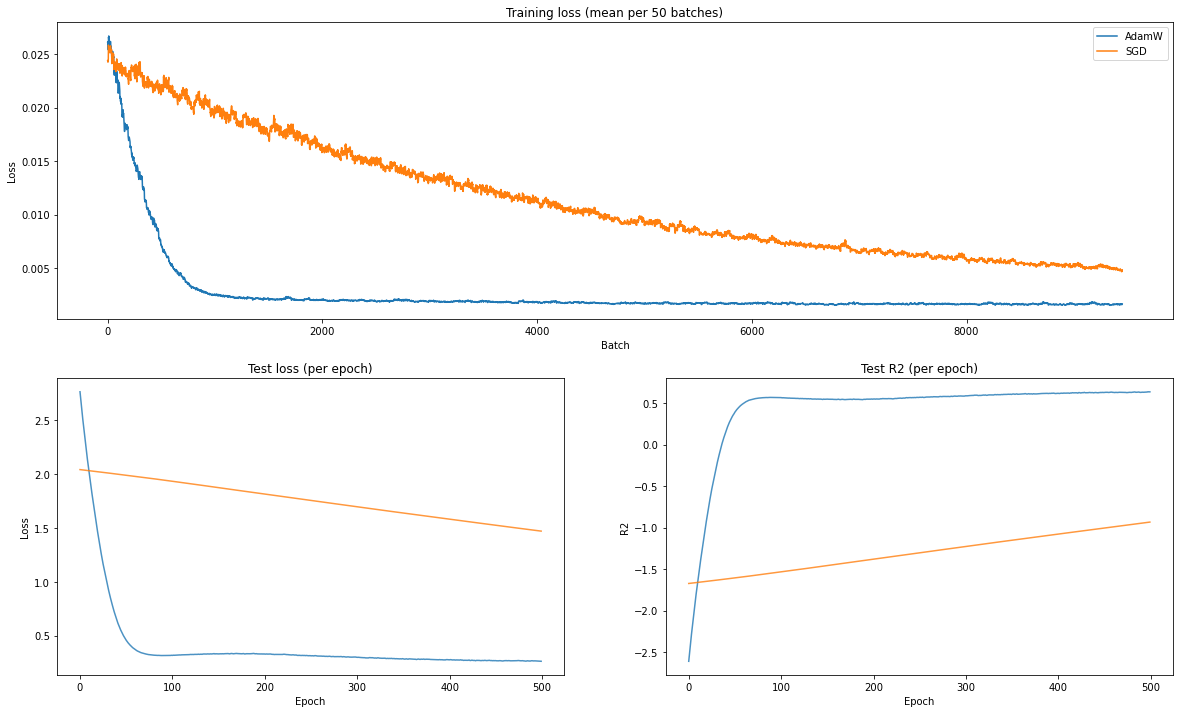

In [31]:
plot_results(experiment_results, fig_name='optimisers_1')

In [32]:
model_adam = Net()
optimiser_adam = optim.AdamW(model_adam.parameters(), lr=0.0001)

model_SGD = Net()
optimiser_SGD = optim.SGD(model_SGD.parameters(), lr=0.0001)

results_adam = train_model(train_dataloader_2, test_dataset_2, 
                             model_adam, optimiser_adam,
                             nn.MSELoss(), 500, 
                             'AdamW')
results_SGD = train_model(train_dataloader_2, test_dataset_2,
                            model_SGD, optimiser_SGD,
                            nn.MSELoss(), 500, 
                            'SGD')

experiment_results = [results_adam, results_SGD]

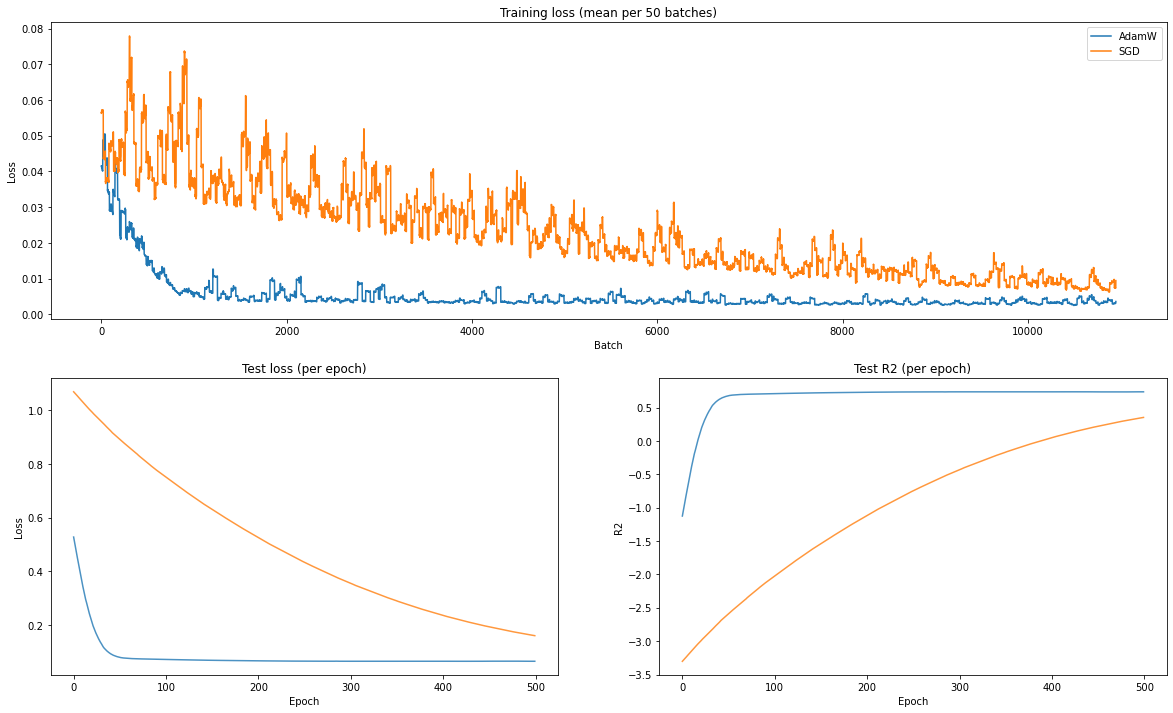

In [33]:
plot_results(experiment_results, fig_name='optimisers_2')

### 2. Learning Rate and Momentum
Since AdamW has clearly arrived at the destination much quicker, we experiment with the learning rate applied to it.

In [34]:
n_experiments = 4
learning_rates = [0.01, 0.001, 0.0001, 0.00001]

In [35]:
models, optimisers = [], []
for i in range(n_experiments):
    model = Net()
    optimiser = optim.AdamW(model.parameters(), lr=learning_rates[i])
    models.append(model)
    optimisers.append(optimiser)

experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader_1, test_dataset_1, 
                                            models[i], optimisers[i],
                                            nn.MSELoss(), 500, 
                                            'lr: {}'.format(str(learning_rates[i]))))

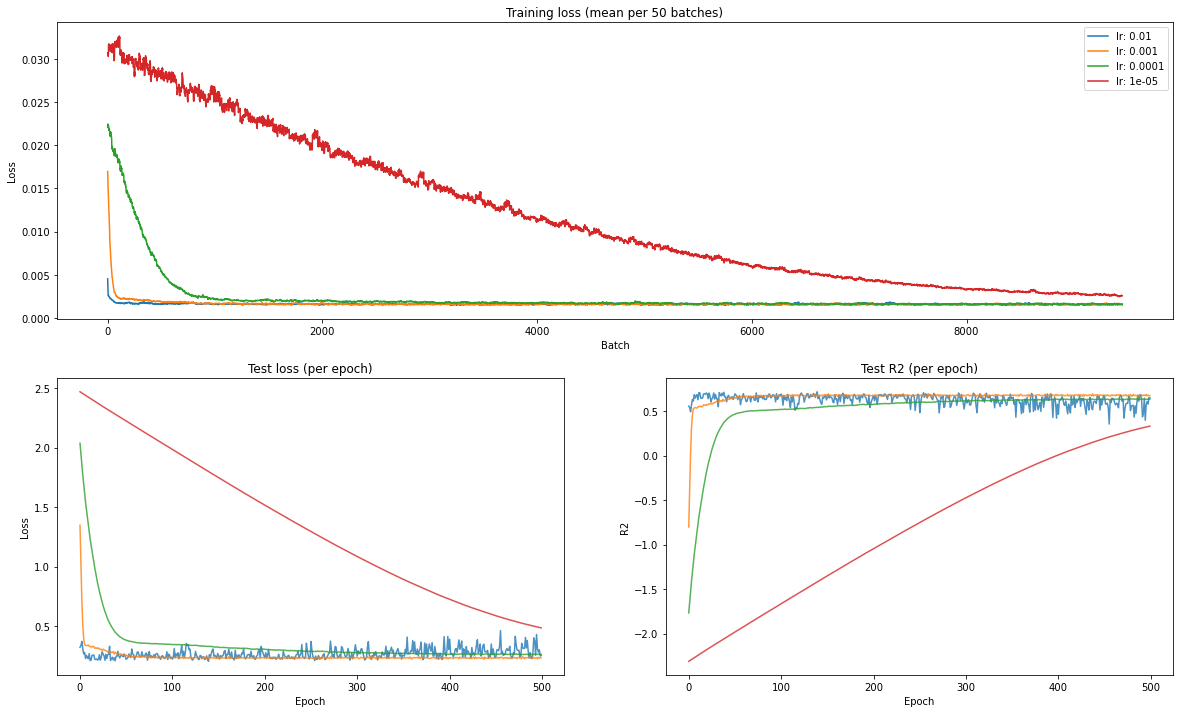

In [36]:
plot_results(experiment_results, fig_name='learning_rates_1')

In [37]:
models, optimisers = [], []
for i in range(n_experiments):
    model = Net()
    optimiser = optim.AdamW(model.parameters(), lr=learning_rates[i])
    models.append(model)
    optimisers.append(optimiser)

experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader_2, test_dataset_2, 
                                            models[i], optimisers[i],
                                            nn.MSELoss(), 500, 
                                            'lr: {}'.format(str(learning_rates[i]))))

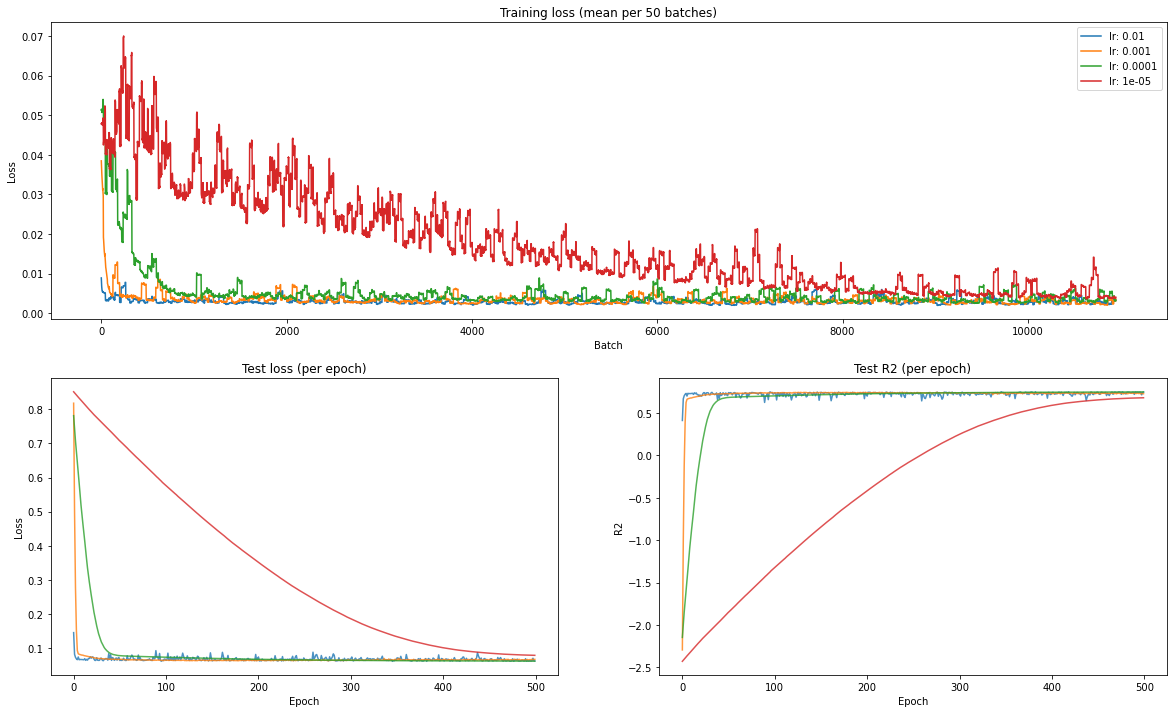

In [38]:
plot_results(experiment_results, fig_name='learning_rates_2')

### 3. Network Depth
Next we experiment with the actual structure of the network which is being trained. In particular, we will try adding layers to the network. To this end, I first define a simple ```QuickNet``` class which takes as initialisation arguments a list of layer sizes.

In [39]:
class QuickNet(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        self.layer_sizes = layer_sizes

        structure = []
        for i in range(len(layer_sizes)):
            if i == len(layer_sizes) - 2:
                structure.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                break
            else:
                structure.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                structure.append(nn.ReLU())

        self.layers = nn.ModuleList(structure)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [40]:
n_experiments = 3
layer_sizes = [
    (5, 32, 5),
    (5, 32, 32, 32, 5),
    (5, 32, 32, 32, 32, 32, 5),
]

In [41]:
models, optimisers = [], []
for i in range(n_experiments):
    model = QuickNet(layer_sizes[i])
    optimiser = optim.AdamW(model.parameters(), lr=0.0001)
    models.append(model)
    optimisers.append(optimiser)

    
experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader_1, test_dataset_1, 
                                            models[i], optimisers[i],
                                            nn.MSELoss(), 1000, 
                                            str(models[i].layer_sizes)))

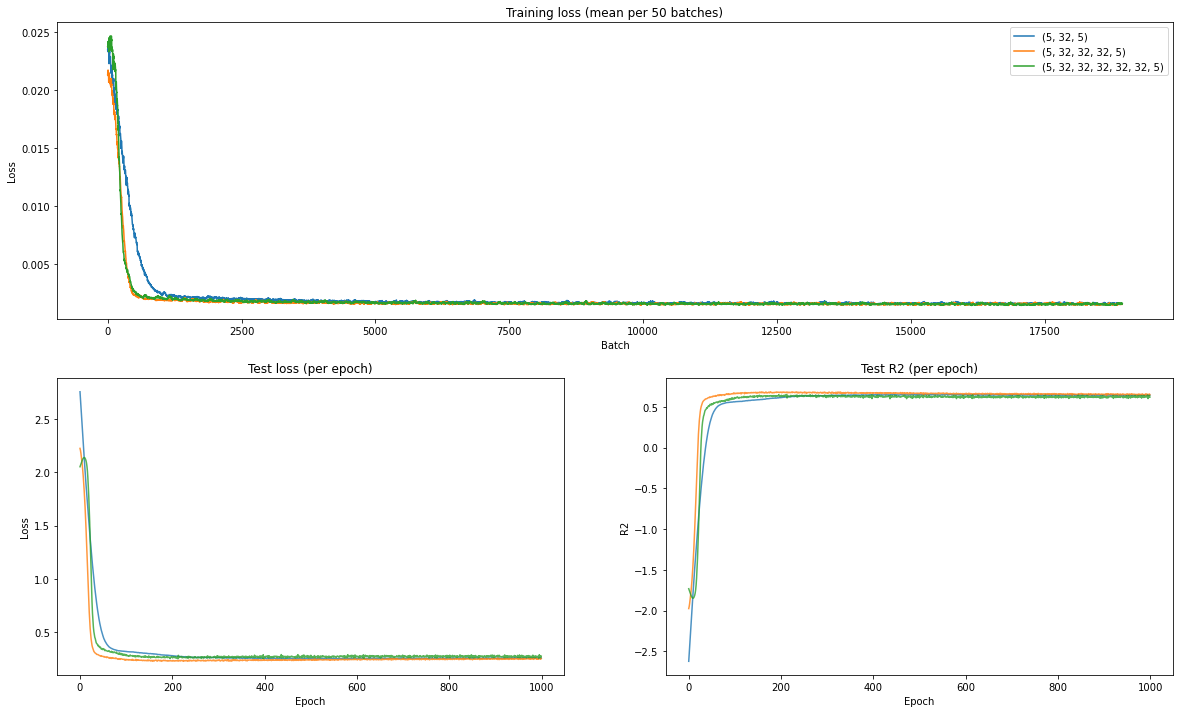

In [42]:
plot_results(experiment_results, fig_name='depth_1')

In [43]:
models, optimisers = [], []
for i in range(n_experiments):
    model = QuickNet(layer_sizes[i])
    optimiser = optim.AdamW(model.parameters(), lr=0.0001)
    models.append(model)
    optimisers.append(optimiser)

    
experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader_2, test_dataset_2, 
                                            models[i], optimisers[i],
                                            nn.MSELoss(), 1000, 
                                            str(models[i].layer_sizes)))

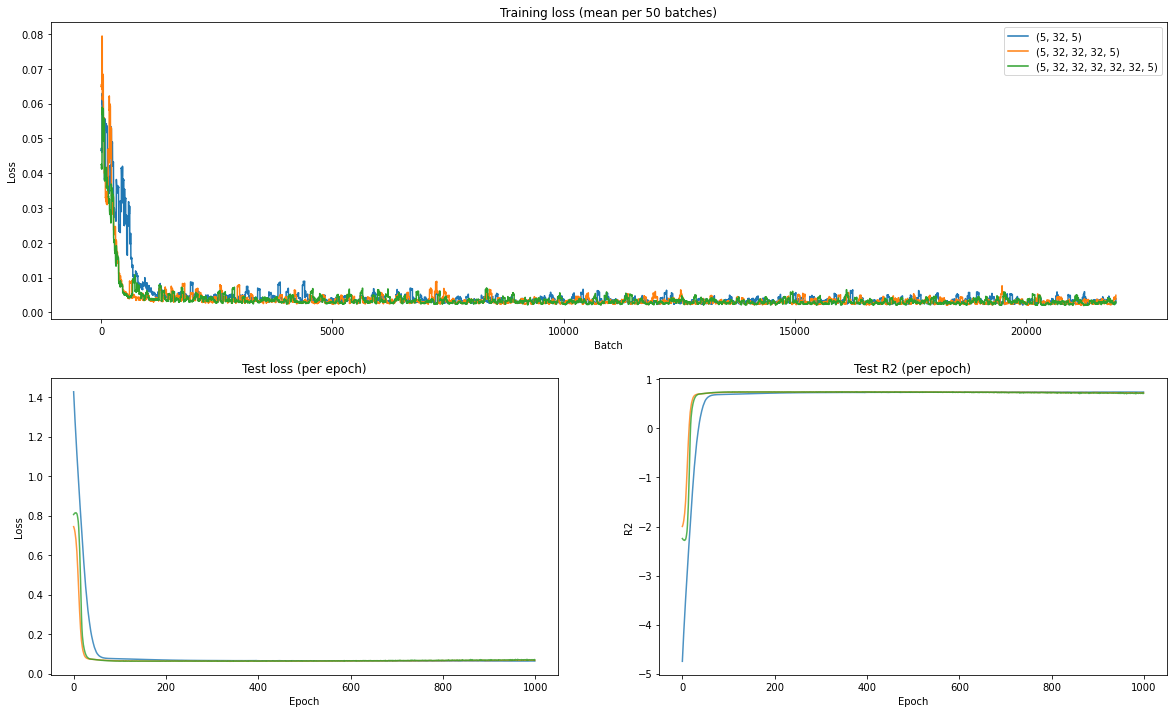

In [44]:
plot_results(experiment_results, fig_name='depth_2')

### 4. Network Width
Last we experiment with the width of the network. This is again done using the ```QuickNet``` class.

In [45]:
n_experiments = 4
layer_sizes = [
    (5, 32, 5),
    (5, 64, 5),
    (5, 128, 5),
    (5, 256, 5)
]

In [46]:
models, optimisers = [], []
for i in range(n_experiments):
    model = QuickNet(layer_sizes[i])
    optimiser = optim.AdamW(model.parameters(), lr=0.0001)
    models.append(model)
    optimisers.append(optimiser)

    
experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader_1, test_dataset_1, 
                                            models[i], optimisers[i],
                                            nn.MSELoss(), 1000, 
                                            str(models[i].layer_sizes)))

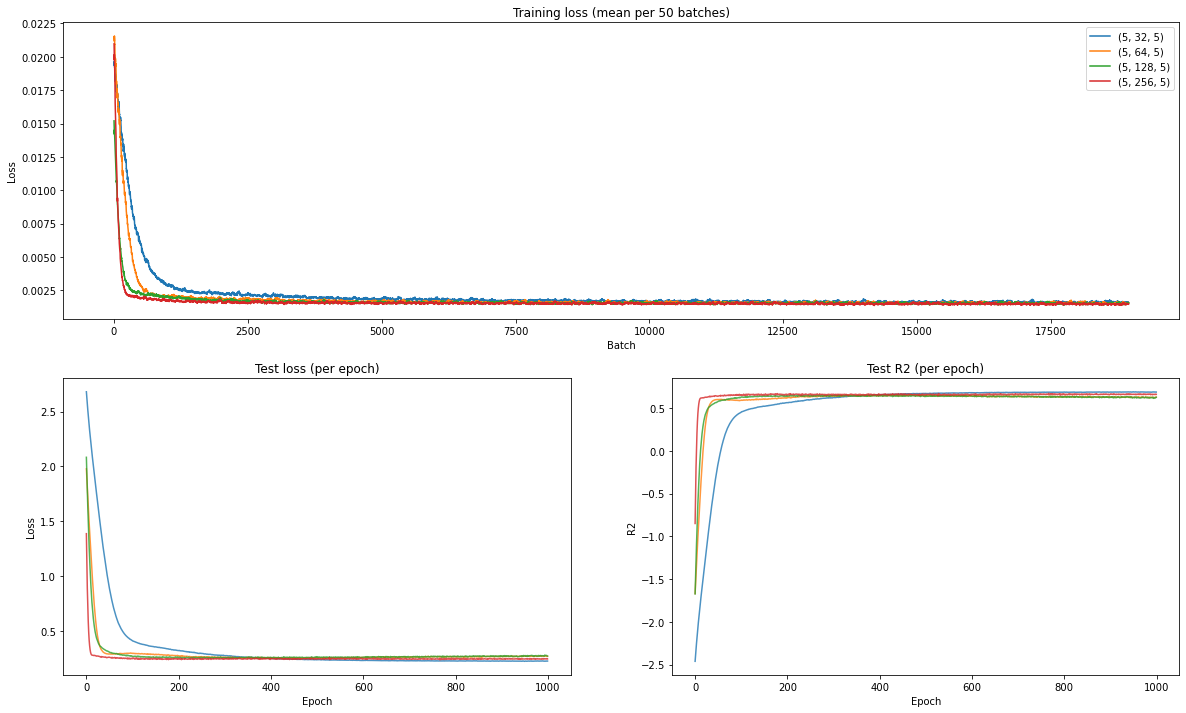

In [47]:
plot_results(experiment_results, fig_name='width_1')

In [48]:
models, optimisers = [], []
for i in range(n_experiments):
    model = QuickNet(layer_sizes[i])
    optimiser = optim.AdamW(model.parameters(), lr=0.0001)
    models.append(model)
    optimisers.append(optimiser)

    
experiment_results = []
for i in range(n_experiments):
    experiment_results.append(train_model(train_dataloader_2, test_dataset_2, 
                                            models[i], optimisers[i],
                                            nn.MSELoss(), 1000, 
                                            str(models[i].layer_sizes)))

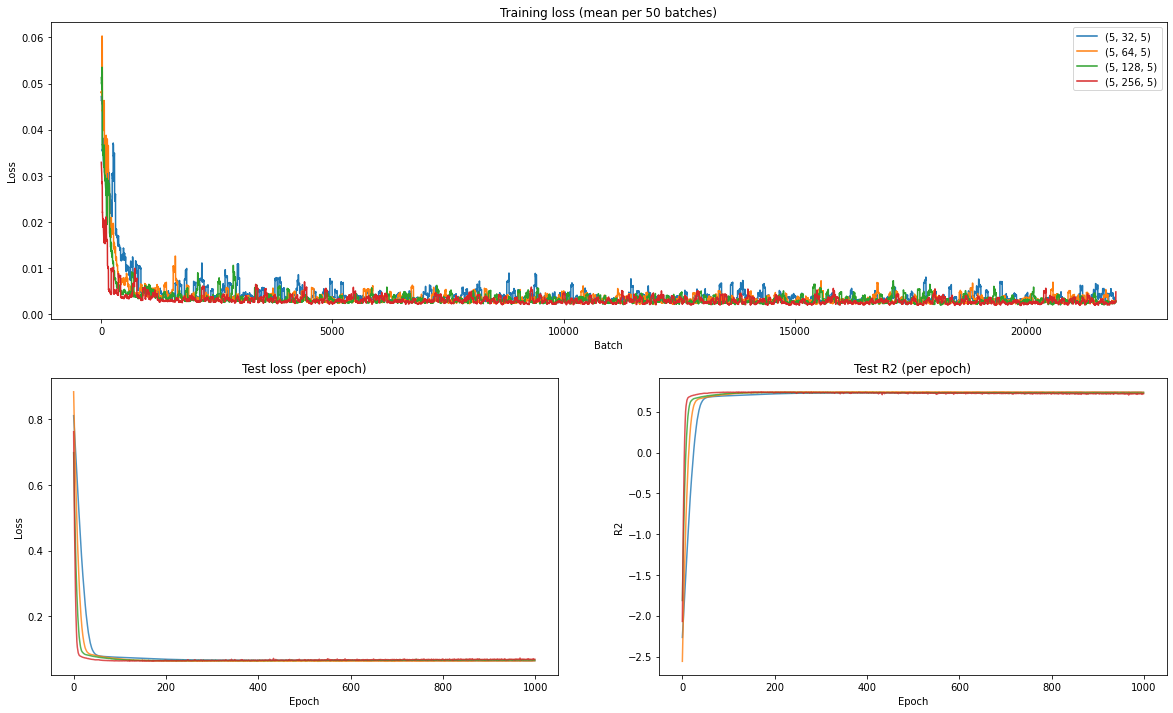

In [49]:
plot_results(experiment_results, fig_name='width_2')

## Evaluation
Across the above, we have explored the performance of various network configurations. It is clear that no matter the permutation, the upper limit of performance is an $R^2$ of just over 0.74.